In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from datetime import date

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
.\btc-price-prediction-lr-svr.ipynb
.\final 562 - Copy.ipynb
.\final 562.ipynb
.\lstm-in-bitcoin.ipynb
.\.ipynb_checkpoints\btc-price-prediction-lr-svr-checkpoint.ipynb
.\.ipynb_checkpoints\final 562 - Copy-checkpoint.ipynb
.\.ipynb_checkpoints\final 562-checkpoint.ipynb
.\.ipynb_checkpoints\lstm-in-bitcoin-checkpoint.ipynb


In [60]:
#import data set
filename = 'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
df = pd.read_csv(filename)
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
#see same sample from data set
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
print(df.Timestamp)

0         2011-12-31 07:52:00
1         2011-12-31 07:53:00
2         2011-12-31 07:54:00
3         2011-12-31 07:55:00
4         2011-12-31 07:56:00
                  ...        
4857372   2021-03-30 23:56:00
4857373   2021-03-30 23:57:00
4857374   2021-03-30 23:58:00
4857375   2021-03-30 23:59:00
4857376   2021-03-31 00:00:00
Name: Timestamp, Length: 4857377, dtype: datetime64[ns]


In [62]:
#Set Timestamp as an index of the dataframe
df.index = df.Timestamp
df.head()
print(df.index)

DatetimeIndex(['2011-12-31 07:52:00', '2011-12-31 07:53:00',
               '2011-12-31 07:54:00', '2011-12-31 07:55:00',
               '2011-12-31 07:56:00', '2011-12-31 07:57:00',
               '2011-12-31 07:58:00', '2011-12-31 07:59:00',
               '2011-12-31 08:00:00', '2011-12-31 08:01:00',
               ...
               '2021-03-30 23:51:00', '2021-03-30 23:52:00',
               '2021-03-30 23:53:00', '2021-03-30 23:54:00',
               '2021-03-30 23:55:00', '2021-03-30 23:56:00',
               '2021-03-30 23:57:00', '2021-03-30 23:58:00',
               '2021-03-30 23:59:00', '2021-03-31 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=4857377, freq=None)


In [63]:
#Resample to daily period

df_day = df.resample('D').mean()
print(df_day.index)

# Find missing values
for i, r in df_day.iterrows():
    if r.isnull().sum() > 0:
        print(i)
        print(r)
        print()



DatetimeIndex(['2011-12-31', '2012-01-01', '2012-01-02', '2012-01-03',
               '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-07',
               '2012-01-08', '2012-01-09',
               ...
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26', '2021-03-27', '2021-03-28', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='Timestamp', length=3379, freq='D')
2015-01-06 00:00:00
Open                NaN
High                NaN
Low                 NaN
Close               NaN
Volume_(BTC)        NaN
Volume_(Currency)   NaN
Weighted_Price      NaN
Name: 2015-01-06 00:00:00, dtype: float64

2015-01-07 00:00:00
Open                NaN
High                NaN
Low                 NaN
Close               NaN
Volume_(BTC)        NaN
Volume_(Currency)   NaN
Weighted_Price      NaN
Name: 2015-01-07 00:00:00, dtype: float64

2015-01-08 00:00:00
Open                NaN
High                NaN
L

In [64]:
#Replace missing value with average values

missing_replacement = df['2015-01-05': '2015-01-09'].mean(numeric_only=True)
df_day.loc['2015-01-06'] = missing_replacement
df_day.loc['2015-01-07'] = missing_replacement
df_day.loc['2015-01-08'] = missing_replacement

# check there is no missing value
df_day.isnull().sum()



Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64

In [65]:
#Set window_size and prepare time series dataset
window_size = (date(2021, 3, 31) - date(2020, 12, 30)).days

df_train = df_day.loc['2017-01-01':'2020-12-30']
df_test = df_day.loc['2020-12-31':]

print(df_test)

df_train['Predicted_Price'] = df_train[['Weighted_Price']].shift(-window_size)
x_train1 = df_train[['Weighted_Price']].values[:-window_size].reshape(-1,1)
y_train = df_train.Predicted_Price.values[:-window_size]

y_test = df_test.Weighted_Price.values

print(df_train)
print("x_train shape=", x_train1.shape)
print("y_train shape=", y_train.shape)
x_train1

                    Open          High           Low         Close  \
Timestamp                                                            
2020-12-31  28881.559417  28903.074500  28857.993639  28882.010653   
2021-01-01  29288.696938  29305.634083  29271.218694  29289.323146   
2021-01-02  30757.308146  30788.244361  30723.941208  30759.932167   
2021-01-03  33467.147104  33507.975028  33425.661465  33468.163000   
2021-01-04  31856.851236  31903.705937  31807.243889  31856.172236   
...                  ...           ...           ...           ...   
2021-03-27  55193.240643  55219.665031  55168.757372  55195.415367   
2021-03-28  55833.608471  55857.735342  55810.425126  55835.012863   
2021-03-29  56914.886595  56946.213593  56885.242967  56915.629993   
2021-03-30  58347.805624  58371.955310  58323.956690  58349.357087   
2021-03-31  58767.750000  58778.180000  58755.970000  58778.180000   

            Volume_(BTC)  Volume_(Currency)  Weighted_Price  
Timestamp                  

C:\Users\wujia\AppData\Local\Temp\ipykernel_12536\4123621123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Predicted_Price'] = df_train[['Weighted_Price']].shift(-window_size)


array([[  981.63768799],
       [ 1013.1994837 ],
       [ 1019.99299463],
       ...,
       [10878.72932483],
       [10729.49535985],
       [10741.21274592]])

In [66]:
#create the linear model
lr = LinearRegression()
lr.fit(x_train1, y_train)

LinearRegression()

In [68]:
# now using the LSTM model 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
temp = df_day.loc['2017-01-01':'2020-12-30']["Weighted_Price"]
temp = np.array(temp)
close_scaled = scaler.fit_transform(temp.reshape(temp.shape[0], 1))

x_train = []
y_train = []
# handle the data to get the input and labels
for i in range(window_size, close_scaled.shape[0]):
    x_train.append(close_scaled[i-window_size:i, 0])
    y_train.append(close_scaled[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("x_train shape=", x_train.shape)
print("y_train shape=", y_train.shape)
print("new x_train shape=", y_train.shape)


#LSTM
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout,Flatten

model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

model.fit(x_train,y_train,epochs=50,batch_size=32)


x_train shape= (1369, 91, 1)
y_train shape= (1369,)
new x_train shape= (1369,)
Epoch 1/50
43/43 [==============================] - 2s 13ms/step - loss: 0.0671
Epoch 2/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0098
Epoch 3/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0050
Epoch 4/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0042
Epoch 5/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0039
Epoch 6/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0037
Epoch 7/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 8/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0032
Epoch 9/50
43/43 [==============================] - 1s 13ms/step - loss: 0.0030
Epoch 10/50
43/43 [==============================] - 1s 12ms/step - loss: 0.0029
Epoch 11/50
43/43 [==============================] - 1s 12ms/step - loss: 0.0027
Epoch 12/50
43/43 [====================

In [69]:
#handle test datas for lstm
data = df_day['Weighted_Price']
inputs = data[len(data) - len(df_test) - window_size:]
print(inputs.shape)
inputs = inputs.values.reshape(-1, 1)
print(inputs.shape)
inputs = scaler.transform(inputs)
inputs[:5]
print(inputs.shape)
x_test = []
for i in range(window_size, inputs.shape[0]):
    x_test.append(inputs[i-window_size:i, 0])
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test.shape)

(182,)
(182, 1)
(182, 1)
(91, 91, 1)


In [70]:
#use the model to predict
predicted_data = model.predict(x_test)
predicted_data = scaler.inverse_transform(predicted_data)
predicted_train_data = model.predict(x_train)
predicted_train_data = scaler.inverse_transform(predicted_train_data)

43/43 [==============================] - 0s 3ms/step


In [71]:
data_test=np.array(df_test['Weighted_Price'])
data_test=data_test.reshape(len(data_test),1)
#get loss
loss = 0
for i in range(len(data_test)):
    loss += pow((data_test[i][0] -predicted_data[i][0]), 2)
loss /= len(data_test)
print(loss)

11943762.023995472


In [73]:
# now using RNN
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

#RNN structure
model=Sequential()
#first RNN layer
model.add(SimpleRNN(32,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.25))
#second RNN layer
model.add(SimpleRNN(64,activation="relu",return_sequences=True))
model.add(Dropout(0.25))
#third RNN layer
model.add(SimpleRNN(128,activation="relu",return_sequences=True))
model.add(Dropout(0.35))
#fourth RNN layer
model.add(SimpleRNN(64,activation="relu",return_sequences=True))
model.add(Dropout(0.25))
#fifth RNN layer
model.add(SimpleRNN(32,activation="relu",return_sequences=True))
model.add(Dropout(0.25))
#convert the matrix to 1-line
model.add(Flatten())
#output layer
model.add(Dense(1))

model.compile(optimizer="adam",loss="mean_squared_error")
model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
43/43 [==============================] - 5s 37ms/step - loss: 0.0146
Epoch 2/50
43/43 [==============================] - 2s 39ms/step - loss: 0.0057
Epoch 3/50
43/43 [==============================] - 2s 39ms/step - loss: 0.0039
Epoch 4/50
43/43 [==============================] - 2s 39ms/step - loss: 0.0033
Epoch 5/50
43/43 [==============================] - 2s 39ms/step - loss: 0.0028
Epoch 6/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0026
Epoch 7/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0027
Epoch 8/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0028
Epoch 9/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0022
Epoch 10/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0019
Epoch 11/50
43/43 [==============================] - 2s 38ms/step - loss: 0.0018
Epoch 12/50
43/43 [==============================] - 2s 39ms/step - loss: 0.0018
Epoch 13/50
43/43 [==================

In [83]:
#handle test datas for lstm
data = df_day['Weighted_Price']
inputs = data[len(data) - len(df_test) - window_size:]
print(inputs.shape)
inputs = inputs.values.reshape(-1, 1)
print(inputs.shape)
inputs = scaler.transform(inputs)
inputs[:5]
print(inputs.shape)
x_test = []
for i in range(window_size, inputs.shape[0]):
    x_test.append(inputs[i-window_size:i, 0])
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test.shape)

(182,)
(182, 1)
(182, 1)
(91, 91, 1)


In [84]:
#use the model to predict
predicted_RNN_data = model.predict(x_test)
predicted_RNN_data = scaler.inverse_transform(predicted_RNN_data)
predicted_train_RNNdata = model.predict(x_train)
predicted_train_RNNdata = scaler.inverse_transform(predicted_train_RNNdata)

43/43 [==============================] - 0s 10ms/step


In [85]:
data_test=np.array(df_test['Weighted_Price'])
data_test=data_test.reshape(len(data_test),1)
#get the lost
loss = 0
for i in range(len(data_test)):
    loss += pow((data_test[i][0] -predicted_data[i][0]), 2)
loss /= len(data_test)
print(loss)

11943762.023995472


[[28200.076]
 [29013.727]
 [29758.47 ]
 [30805.947]
 [32413.818]
 [32976.93 ]
 [33750.37 ]
 [35221.918]
 [37253.016]
 [39228.01 ]
 [40895.38 ]
 [41940.168]
 [40767.06 ]
 [40662.54 ]
 [40351.17 ]
 [41502.227]
 [41494.51 ]
 [41374.26 ]
 [40871.37 ]
 [40738.098]
 [40843.473]
 [40155.145]
 [39000.406]
 [37946.055]
 [37389.258]
 [36811.023]
 [36758.87 ]
 [36100.426]
 [35461.168]
 [35271.62 ]
 [36164.46 ]
 [36169.934]
 [36128.58 ]
 [36268.79 ]
 [36710.816]
 [37616.086]
 [38494.28 ]
 [39150.   ]
 [40492.566]
 [40903.71 ]
 [42329.066]
 [45266.816]
 [46589.934]
 [47996.945]
 [49572.293]
 [50444.242]
 [51689.47 ]
 [52062.64 ]
 [52816.062]
 [54050.39 ]
 [55016.324]
 [56053.844]
 [58004.48 ]
 [59211.176]
 [58816.1  ]
 [56140.465]
 [55418.94 ]
 [54613.395]
 [52398.336]
 [51488.81 ]
 [49630.773]
 [49808.55 ]
 [49811.113]
 [50448.895]
 [50222.254]
 [49563.387]
 [49626.992]
 [50325.3  ]
 [50809.67 ]
 [52480.312]
 [53847.74 ]
 [55102.844]
 [56167.062]
 [57758.594]
 [59329.59 ]
 [58803.473]
 [57900.266]

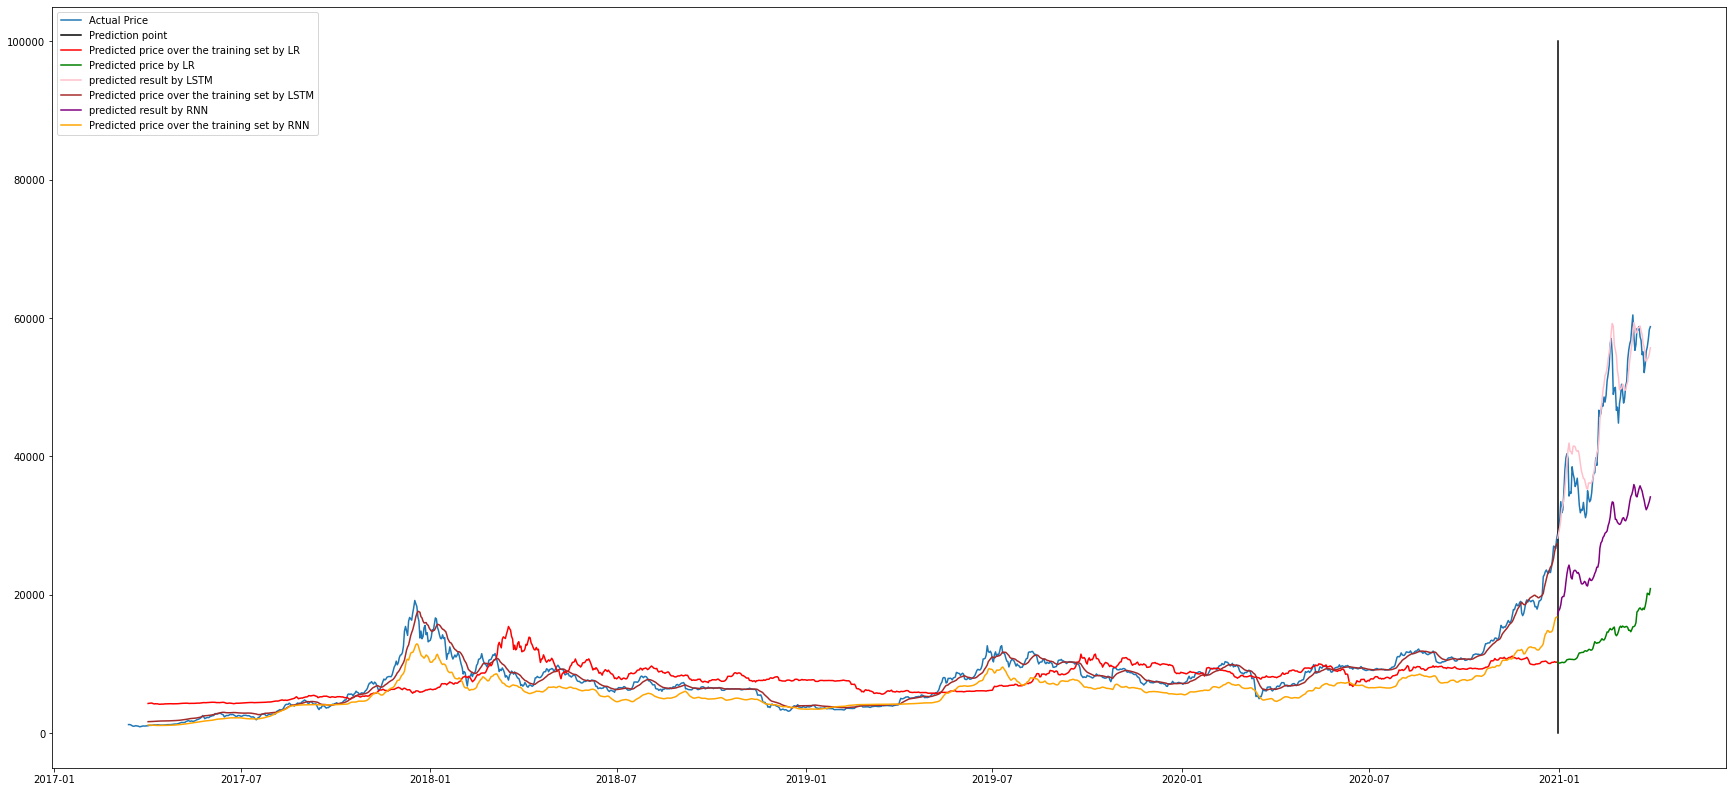

In [93]:
#plot the data from three models
plt.figure(figsize=(30,14))
plt.plot(df_day.index.values[1900:], df_day.Weighted_Price.values[1900:], label='Actual Price')
plt.plot([date(2020, 12, 31), date(2020, 12, 31)], [0, 100000], 'black', 
         label='Prediction point')

y_predict_lr = lr.predict(x_train1)
plt.plot(df_train.index.values[window_size:], y_predict_lr, 'red', 
         label='Predicted price over the training set by LR')

y_predict_lr_test = lr.predict(
    df_train[-window_size:].Weighted_Price.values.reshape(-1, 1)
)
plt.plot(df_test.index.values[:window_size], y_predict_lr_test, 'green', 
         label='Predicted price by LR')

print(predicted_data)

plt.plot(df_day.index[-91:],predicted_data,color="pink",label="predicted result by LSTM")
plt.plot(df_train.index.values[window_size:],predicted_train_data,color="brown",label="Predicted price over the training set by LSTM")

plt.plot(df_day.index[-91:],predicted_RNN_data,color="purple",label="predicted result by RNN")
plt.plot(df_train.index.values[window_size:],predicted_train_RNNdata,color="orange",label="Predicted price over the training set by RNN")

plt.legend()

In [88]:
#get the MSE of three models
mean_squared_error(y_test, y_predict_lr_test, squared=False),mean_squared_error(y_test, predicted_data, squared=False),mean_squared_error(y_test, predicted_RNN_data, squared=False)

(31878.33373339635, 3455.9748297687993, 17961.22429332689)

[[28200.076]
 [29013.727]
 [29758.47 ]
 [30805.947]
 [32413.818]
 [32976.93 ]
 [33750.37 ]
 [35221.918]
 [37253.016]
 [39228.01 ]
 [40895.38 ]
 [41940.168]
 [40767.06 ]
 [40662.54 ]
 [40351.17 ]
 [41502.227]
 [41494.51 ]
 [41374.26 ]
 [40871.37 ]
 [40738.098]
 [40843.473]
 [40155.145]
 [39000.406]
 [37946.055]
 [37389.258]
 [36811.023]
 [36758.87 ]
 [36100.426]
 [35461.168]
 [35271.62 ]
 [36164.46 ]
 [36169.934]
 [36128.58 ]
 [36268.79 ]
 [36710.816]
 [37616.086]
 [38494.28 ]
 [39150.   ]
 [40492.566]
 [40903.71 ]
 [42329.066]
 [45266.816]
 [46589.934]
 [47996.945]
 [49572.293]
 [50444.242]
 [51689.47 ]
 [52062.64 ]
 [52816.062]
 [54050.39 ]
 [55016.324]
 [56053.844]
 [58004.48 ]
 [59211.176]
 [58816.1  ]
 [56140.465]
 [55418.94 ]
 [54613.395]
 [52398.336]
 [51488.81 ]
 [49630.773]
 [49808.55 ]
 [49811.113]
 [50448.895]
 [50222.254]
 [49563.387]
 [49626.992]
 [50325.3  ]
 [50809.67 ]
 [52480.312]
 [53847.74 ]
 [55102.844]
 [56167.062]
 [57758.594]
 [59329.59 ]
 [58803.473]
 [57900.266]

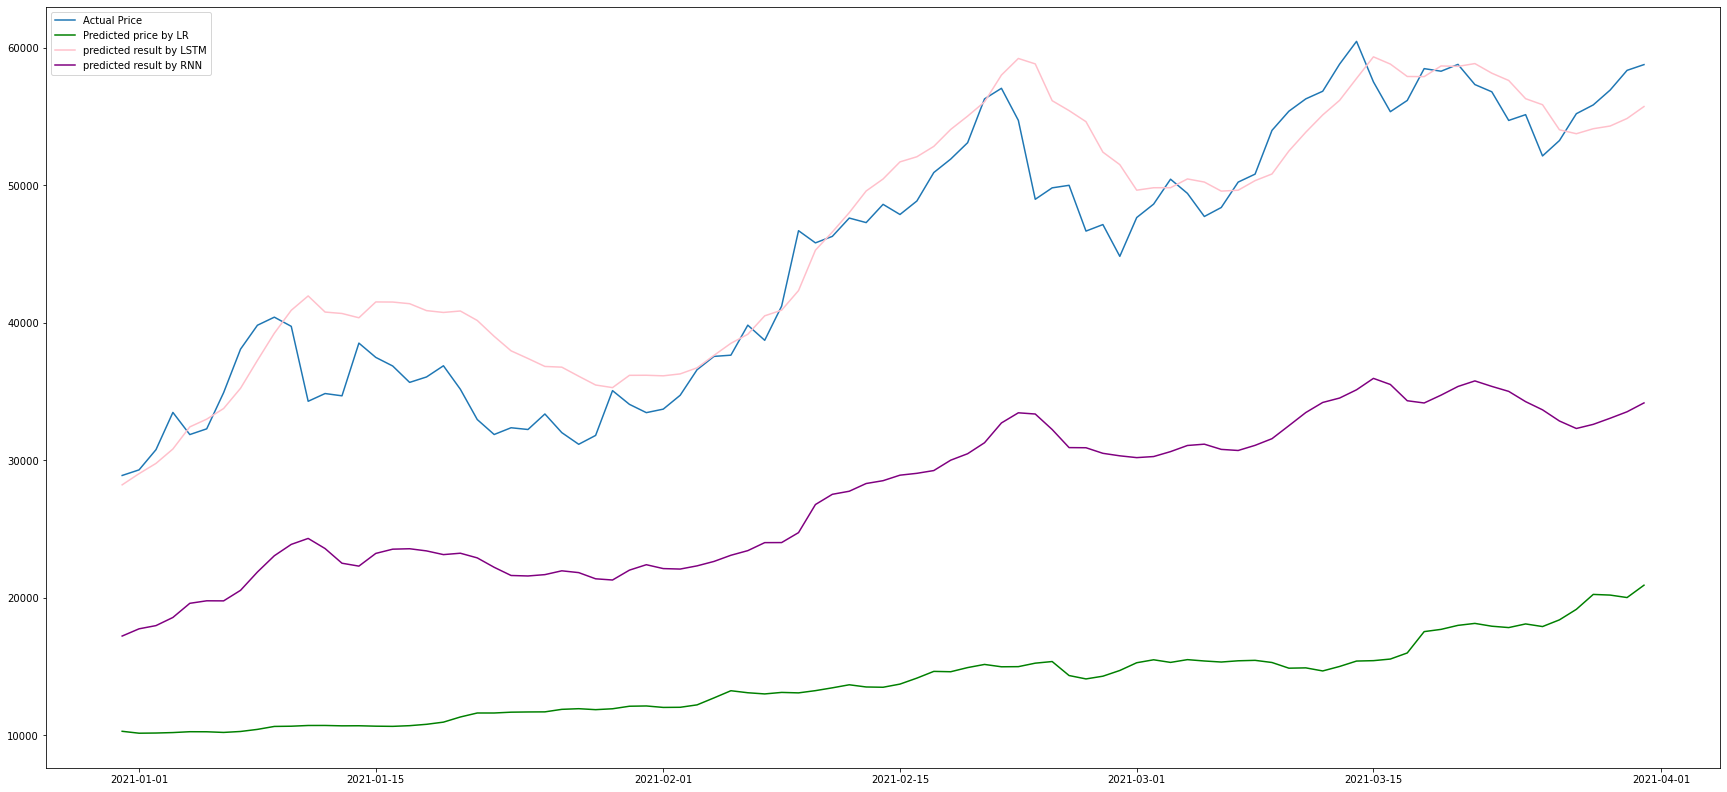

In [91]:
#plot the data from three models

plt.figure(figsize=(30,14))
plt.plot(df_day.index[-91:], df_day.Weighted_Price.values[-91:], label='Actual Price')

y_predict_lr = lr.predict(x_train1)

y_predict_lr_test = lr.predict(
    df_train[-window_size:].Weighted_Price.values.reshape(-1, 1)
)
plt.plot(df_test.index.values[:window_size], y_predict_lr_test, 'green', 
         label='Predicted price by LR')

print(predicted_data)

plt.plot(df_day.index[-91:],predicted_data,color="pink",label="predicted result by LSTM")


plt.plot(df_day.index[-91:],predicted_RNN_data,color="purple",label="predicted result by RNN")


plt.legend()